# 🎯 DINOv3 Fine-tuning + YOLOv12 Object Detection

**Assignment 2: Self-Supervised Learning - Phase 2: Fine-tuning**

This notebook uses **DINOv3 features** for downstream tasks and integrates with **YOLOv12** for object detection, following the teacher's example pattern (DINOv3 distillation → YOLO).

---

## 📋 Pipeline Overview (Following Teacher's Example)

| # | Step | Description | Output |
|---|------|-------------|--------|
| **1** | Environment Setup | Install dependencies, configure GPU | Ready environment |
| **2** | Load Features | Load pre-extracted DINOv3 features | Feature arrays |
| **3** | Linear Evaluation | Train logistic regression classifier | Accuracy metrics |
| **4** | k-NN Classification | Evaluate with k-Nearest Neighbors | k-NN accuracy |
| **5** | MLP Classifier | Train neural network classifier | Best accuracy |
| **6** | YOLOv12 Integration | Fine-tune YOLOv12 with DINOv3 knowledge | Detection model |
| **7** | Visualization | Predictions with bounding boxes & counts | Visual results |
| **8** | Confusion Matrix | Display training analysis | Plots |

---

## 📚 Table of Contents

1. [Introduction](#1-introduction)
2. [Environment Setup](#2-environment-setup)
3. [Configuration](#3-configuration)
4. [Load Features](#4-load-features)
5. [Linear Evaluation](#5-linear-evaluation)
6. [k-NN Classification](#6-k-nn-classification)
7. [MLP Classifier](#7-mlp-classifier)
8. [Training Curves](#8-training-curves)
9. [Comprehensive Evaluation](#9-comprehensive-evaluation)
10. [YOLOv12 Object Detection](#10-yolov12-object-detection)
11. [Results Summary](#11-results-summary)

---

## 1. Introduction

### Evaluation Protocols for Self-Supervised Features

We evaluate DINOv3 features using three standard protocols:

1. **Linear Evaluation**: Train a logistic regression classifier
   - Tests raw feature quality
   - Standard SSL benchmark

2. **k-NN Classification**: Use k-Nearest Neighbors
   - No training required
   - Directly tests feature space quality

3. **MLP Classifier**: Train a multi-layer perceptron
   - Learns non-linear decision boundaries
   - Usually achieves best performance

### Why DINOv3 Features Excel:

- **Gram Anchoring**: Novel regularizer improving patch-level consistency
- **Massive Scale**: Trained on 1.7B images (LVD-1689M dataset)
- **Large Models**: Up to 7B parameters available
- **Universal Backbone**: Works out-of-the-box on diverse tasks without fine-tuning
- **Dense Predictions**: State-of-the-art on segmentation and detection tasks
- **Official Support**: Available via Hugging Face Transformers (v4.56.0+)

### DINOv3 Model Used:

**`facebook/dinov3-vitb16-pretrain-lvd1689m`**
- Architecture: Vision Transformer Base/16
- Parameters: 86M
- Feature Dimension: 768
- Pretraining: 1.7 billion web images
- Source: Hugging Face Transformers

```
┌─────────────────────────────────────────────────────────┐
│              DINOv3 Pre-extracted Features              │
│         (768-dimensional from ViT-B/16)                 │
│         Meta AI - Hugging Face Official                 │
└────────────────────────┬────────────────────────────────┘
                         │
         ┌───────────────┼───────────────┐
         ▼               ▼               ▼
   ┌───────────┐   ┌───────────┐   ┌───────────┐
   │  Linear   │   │   k-NN    │   │    MLP    │
   │ (LogReg)  │   │           │   │ Classifier│
   └─────┬─────┘   └─────┬─────┘   └─────┬─────┘
         │               │               │
         └───────────────┼───────────────┘
                         ▼
                 Classification Metrics
```

## 2. Environment Setup

In [1]:
# ============================================
# STEP 1: Install & Import Libraries (LOCAL)
# ============================================
import subprocess
import sys

print("📦 Installing/Upgrading packages for LOCAL execution...")

%pip install transformers huggingface_hub torch torchvision ultralytics scikit-learn matplotlib seaborn pandas numpy tqdm --upgrade

# ============================================
# Imports
# ============================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc, 
    roc_auc_score, precision_recall_curve
)
from sklearn.preprocessing import label_binarize

# Seaborn
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
sns.set_style('whitegrid')

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ============================================
# GPU Configuration (LOCAL with NVIDIA)
# ============================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🎯 Device: {device}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"   CUDA: {torch.version.cuda}")
    # Enable optimizations for faster computation
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
else:
    print("   ⚠️ No GPU detected! Check CUDA installation.")

print(f"\n📦 PyTorch: {torch.__version__}")
print("✅ All imports successful!")

📦 Installing/Upgrading packages for LOCAL execution...



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached huggingface_hub-1.2.3-py3-none-any.whl.metadata (13 kB)
  Using cached numpy-2.3.5-cp313-cp313-win_amd64.whl.metadata (60 kB)
Note: you may need to restart the kernel to use updated packages.

🎯 Device: cuda
   GPU: NVIDIA GeForce RTX 3070
   VRAM: 8.0 GB
   CUDA: 13.0

📦 PyTorch: 2.9.1+cu130
✅ All imports successful!


## 3. Configuration

In [2]:
# ============================================
# Configuration (LOCAL PATHS)
# ============================================
class Config:
    """DINOv3 Fine-tuning + YOLO Integration Configuration - LOCAL SETUP"""
    
    # ============================================
    # LOCAL PATHS - UPDATE IF NEEDED
    # ============================================
    BASE_DIR = Path(".")
    DATASET_NAME = "brain-mri-split-dataset-v2"
    
    # Features from 04_1 notebook
    FEATURES_DIR = BASE_DIR / "dino_features"
    
    # Dataset paths
    DATA_DIR = BASE_DIR / DATASET_NAME / "dataset"
    DATA_YAML = BASE_DIR / DATASET_NAME / "data.yaml"
    
    # Output directory
    OUTPUT_DIR = BASE_DIR / "dino_finetuning_output"
    
    # YOLOv12 weights
    YOLOV12_WEIGHTS = BASE_DIR / DATASET_NAME / "yolov12-best.pt"
    
    # Feature prefix (must match 04_1 notebook output)
    FEATURES_PREFIX = 'dino_features'
    
    # Model Configuration
    # Using DINOv3 ViT-L/16 (1024 dim) or DINOv2 fallback
    FEATURE_DIM = 1024  # DINOv3 ViT-Large (matches 04_1 notebook)
    
    # Classes
    CLASS_NAMES = ['cct', 'ifc', 'uas']
    NUM_CLASSES = 3
    
    # MLP Training (can increase batch size for local GPU)
    MLP_EPOCHS = 50
    MLP_BATCH_SIZE = 64  # Increased for local GPU
    MLP_LR = 1e-3
    MLP_WEIGHT_DECAY = 1e-4
    MLP_HIDDEN_DIM = 256
    MLP_DROPOUT = 0.3
    
    # k-NN
    KNN_K_VALUES = [1, 3, 5, 10, 20]
    
    # YOLO Fine-tuning
    YOLO_EPOCHS = 20
    YOLO_IMGSZ = 640
    YOLO_BATCH = 16  # Increased for local GPU

config = Config()
config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*60)
print("📋 DINO FINE-TUNING CONFIGURATION (LOCAL)")
print("="*60)
print(f"  Features Dir: {config.FEATURES_DIR}")
print(f"  Data Dir: {config.DATA_DIR}")
print(f"  Output Dir: {config.OUTPUT_DIR}")
print(f"  Feature Dim: {config.FEATURE_DIM}")
print(f"  Classes: {config.CLASS_NAMES}")
print(f"  MLP Epochs: {config.MLP_EPOCHS}")
print(f"  MLP Batch Size: {config.MLP_BATCH_SIZE}")
print(f"  YOLO Weights: {config.YOLOV12_WEIGHTS}")
print("="*60)

# Verify paths exist
print("\n📂 Path Verification:")
for name, path in [
    ("Features Dir", config.FEATURES_DIR),
    ("Data Dir", config.DATA_DIR),
    ("YOLO Weights", config.YOLOV12_WEIGHTS)
]:
    if path.exists():
        print(f"   ✅ {name}: {path}")
    else:
        print(f"   ⚠️ {name}: NOT FOUND - {path}")

📋 DINO FINE-TUNING CONFIGURATION (LOCAL)
  Features Dir: dino_features
  Data Dir: brain-mri-split-dataset-v2\dataset
  Output Dir: dino_finetuning_output
  Feature Dim: 1024
  Classes: ['cct', 'ifc', 'uas']
  MLP Epochs: 50
  MLP Batch Size: 64
  YOLO Weights: brain-mri-split-dataset-v2\yolov12-best.pt

📂 Path Verification:
   ✅ Features Dir: dino_features
   ✅ Data Dir: brain-mri-split-dataset-v2\dataset
   ✅ YOLO Weights: brain-mri-split-dataset-v2\yolov12-best.pt


## 4. Load Features

In [3]:
# ============================================
# Load Pre-extracted Features
# ============================================
def load_features(features_dir, prefix):
    """Load pre-extracted DINO features from 04_1 notebook."""
    data = {}
    
    # Check for both 'val' and 'valid' naming conventions
    split_mapping = {
        'train': ['train'],
        'val': ['val', 'valid'],
        'test': ['test']
    }
    
    for target_split, possible_names in split_mapping.items():
        found = False
        for split_name in possible_names:
            feat_path = features_dir / f'{prefix}_{split_name}_features.npy'
            lbl_path = features_dir / f'{prefix}_{split_name}_labels.npy'
            
            if feat_path.exists() and lbl_path.exists():
                data[f'{target_split}_features'] = np.load(feat_path)
                data[f'{target_split}_labels'] = np.load(lbl_path)
                print(f"   ✅ Loaded {target_split}: {data[f'{target_split}_features'].shape}")
                found = True
                break
        
        if not found:
            print(f"   ❌ {target_split} features not found!")
            print(f"\n{'='*70}")
            print("ERROR: Pre-extracted DINO features not found!")
            print("="*70)
            print(f"\nExpected location: {features_dir}")
            print(f"Looking for: {prefix}_<split>_features.npy")
            print(f"\n📌 Solution:")
            print("  1. Run '04_1_DINOv3_FeatureExtraction.ipynb' first")
            print("  2. Make sure features are saved to:", features_dir)
            print("="*70)
            
            # List what files exist in the directory
            if features_dir.exists():
                print(f"\nFiles found in {features_dir}:")
                for f in features_dir.iterdir():
                    print(f"   - {f.name}")
            raise FileNotFoundError(f"Features not found in {features_dir}")
    
    return data


print("📂 Loading pre-extracted DINO features...")
print(f"   From: {config.FEATURES_DIR}")
print()

data = load_features(config.FEATURES_DIR, config.FEATURES_PREFIX)

# Extract
train_features = data['train_features']
train_labels = data['train_labels']
val_features = data['val_features']
val_labels = data['val_labels']
test_features = data['test_features']
test_labels = data['test_labels']

print(f"\n📊 Feature Shapes:")
print(f"   Train: {train_features.shape}")
print(f"   Val: {val_features.shape}")
print(f"   Test: {test_features.shape}")

# Verify feature dimension matches config
actual_dim = train_features.shape[1]
if actual_dim != config.FEATURE_DIM:
    print(f"\n⚠️ Feature dimension mismatch!")
    print(f"   Config: {config.FEATURE_DIM}, Actual: {actual_dim}")
    print(f"   Updating config.FEATURE_DIM to {actual_dim}")
    config.FEATURE_DIM = actual_dim

print(f"\n📈 Label Distribution:")
for split_name, split_labels in [('Train', train_labels), ('Val', val_labels), ('Test', test_labels)]:
    print(f"   {split_name}:")
    for cls_id, cls_name in enumerate(config.CLASS_NAMES):
        count = (split_labels == cls_id).sum()
        pct = count / len(split_labels) * 100
        print(f"      {cls_name}: {count} ({pct:.1f}%)")

📂 Loading pre-extracted DINO features...
   From: dino_features

   ✅ Loaded train: (1810, 1024)
   ✅ Loaded val: (226, 1024)
   ✅ Loaded test: (227, 1024)

📊 Feature Shapes:
   Train: (1810, 1024)
   Val: (226, 1024)
   Test: (227, 1024)

📈 Label Distribution:
   Train:
      cct: 928 (51.3%)
      ifc: 693 (38.3%)
      uas: 189 (10.4%)
   Val:
      cct: 117 (51.8%)
      ifc: 79 (35.0%)
      uas: 30 (13.3%)
   Test:
      cct: 126 (55.5%)
      ifc: 76 (33.5%)
      uas: 25 (11.0%)


### 4.1 Feature EDA

Let's analyze the extracted DINOv3 features before training classifiers.

📊 FEATURE EXPLORATORY DATA ANALYSIS


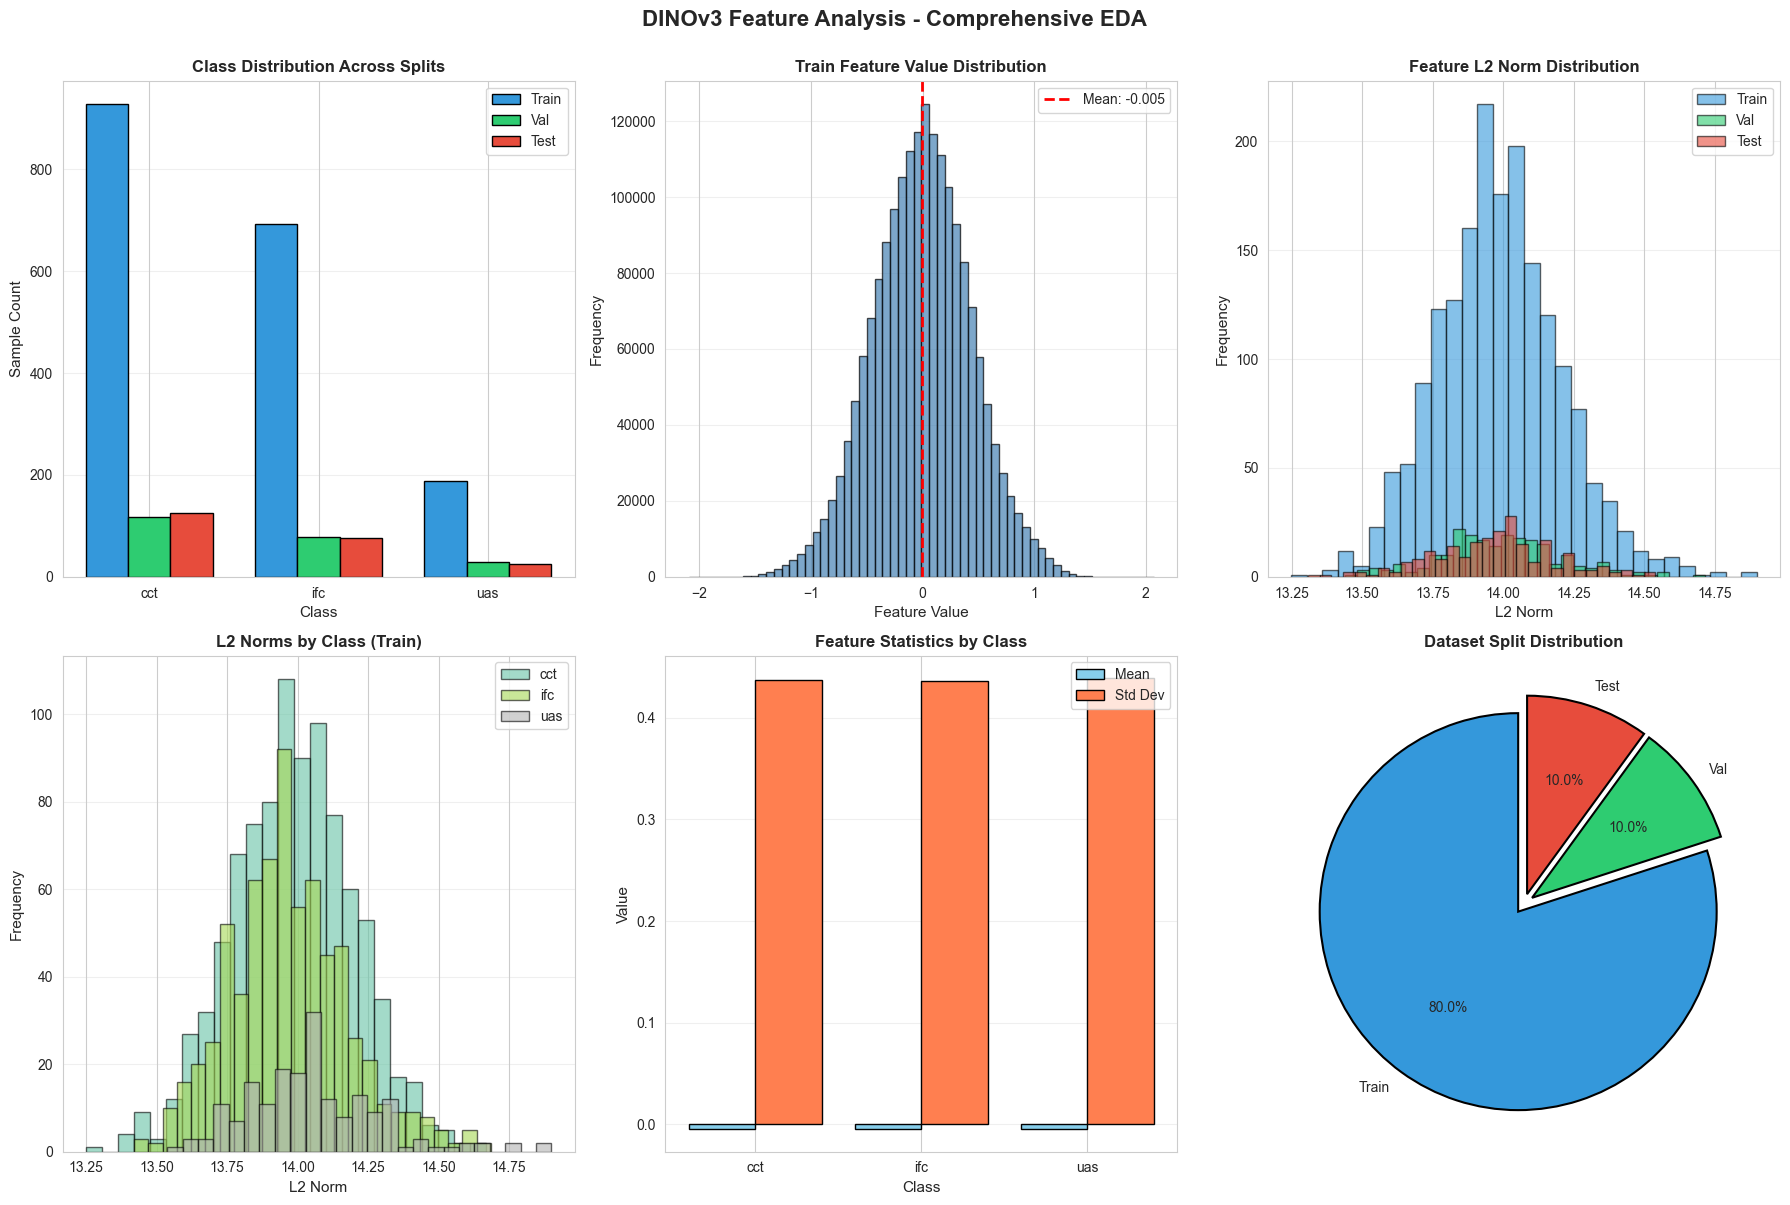


💾 Saved: dino_finetuning_output\dinov3_feature_eda.png

📊 Feature Statistics Summary:
   Feature Dimension: 1024

   Training Set:
      Mean: -0.0048
      Std: 0.4371
      Min: -2.0954
      Max: 2.0724
      L2 Norm (avg): 13.9864

   Per-Class Statistics (Training):
      cct:
         Count: 928
         Feature Mean: -0.0047
         L2 Norm Mean: 13.9851
      ifc:
         Count: 693
         Feature Mean: -0.0049
         L2 Norm Mean: 13.9696
      uas:
         Count: 189
         Feature Mean: -0.0047
         L2 Norm Mean: 14.0544


In [4]:
# ==================================
# COMPREHENSIVE FEATURE EDA
# ==================================
print("=" * 70)
print("📊 FEATURE EXPLORATORY DATA ANALYSIS")
print("=" * 70)

fig = plt.figure(figsize=(18, 12))

# 1. Class Distribution Across Splits
ax1 = fig.add_subplot(2, 3, 1)
splits = ['Train', 'Val', 'Test']
all_split_labels = [train_labels, val_labels, test_labels]
x = np.arange(config.NUM_CLASSES)
width = 0.25
colors_bar = ['#3498db', '#2ecc71', '#e74c3c']

for i, (split, labels, color) in enumerate(zip(splits, all_split_labels, colors_bar)):
    counts = [(labels == c).sum() for c in range(config.NUM_CLASSES)]
    ax1.bar(x + i * width, counts, width, label=split, color=color, edgecolor='black')

ax1.set_xlabel('Class', fontsize=11)
ax1.set_ylabel('Sample Count', fontsize=11)
ax1.set_title('Class Distribution Across Splits', fontweight='bold')
ax1.set_xticks(x + width)
ax1.set_xticklabels(config.CLASS_NAMES)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Feature Value Distribution
ax2 = fig.add_subplot(2, 3, 2)
ax2.hist(train_features.flatten(), bins=60, alpha=0.7, color='steelblue', edgecolor='black')
ax2.set_xlabel('Feature Value', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Train Feature Value Distribution', fontweight='bold')
ax2.axvline(train_features.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {train_features.mean():.3f}')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Feature L2 Norms
ax3 = fig.add_subplot(2, 3, 3)
train_norms = np.linalg.norm(train_features, axis=1)
val_norms = np.linalg.norm(val_features, axis=1)
test_norms = np.linalg.norm(test_features, axis=1)

ax3.hist(train_norms, bins=30, alpha=0.6, label='Train', color='#3498db', edgecolor='black')
ax3.hist(val_norms, bins=30, alpha=0.6, label='Val', color='#2ecc71', edgecolor='black')
ax3.hist(test_norms, bins=30, alpha=0.6, label='Test', color='#e74c3c', edgecolor='black')
ax3.set_xlabel('L2 Norm', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Feature L2 Norm Distribution', fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Per-Class L2 Norms
ax4 = fig.add_subplot(2, 3, 4)
colors_class = plt.cm.Set2(np.linspace(0, 1, config.NUM_CLASSES))
for cls_id, cls_name in enumerate(config.CLASS_NAMES):
    mask = train_labels == cls_id
    if mask.sum() > 0:
        cls_norms = train_norms[mask]
        ax4.hist(cls_norms, bins=25, alpha=0.6, label=cls_name, 
                color=colors_class[cls_id], edgecolor='black')

ax4.set_xlabel('L2 Norm', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('L2 Norms by Class (Train)', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Feature Statistics by Class
ax5 = fig.add_subplot(2, 3, 5)
class_means = []
class_stds = []
for cls_id in range(config.NUM_CLASSES):
    mask = train_labels == cls_id
    if mask.sum() > 0:
        class_means.append(train_features[mask].mean())
        class_stds.append(train_features[mask].std())

x_cls = np.arange(config.NUM_CLASSES)
bars1 = ax5.bar(x_cls - 0.2, class_means, 0.4, label='Mean', color='skyblue', edgecolor='black')
bars2 = ax5.bar(x_cls + 0.2, class_stds, 0.4, label='Std Dev', color='coral', edgecolor='black')

ax5.set_xlabel('Class', fontsize=11)
ax5.set_ylabel('Value', fontsize=11)
ax5.set_title('Feature Statistics by Class', fontweight='bold')
ax5.set_xticks(x_cls)
ax5.set_xticklabels(config.CLASS_NAMES)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Sample Size Pie Chart
ax6 = fig.add_subplot(2, 3, 6)
split_sizes = [len(train_features), len(val_features), len(test_features)]
colors_pie = ['#3498db', '#2ecc71', '#e74c3c']
explode = (0.05, 0.05, 0.05)
ax6.pie(split_sizes, labels=['Train', 'Val', 'Test'], autopct='%1.1f%%', 
        colors=colors_pie, explode=explode, startangle=90, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax6.set_title('Dataset Split Distribution', fontweight='bold')

plt.suptitle('DINOv3 Feature Analysis - Comprehensive EDA', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_feature_eda.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n💾 Saved: {config.OUTPUT_DIR / 'dinov3_feature_eda.png'}")

# Print detailed statistics
print(f"\n📊 Feature Statistics Summary:")
print(f"   Feature Dimension: {train_features.shape[1]}")
print(f"\n   Training Set:")
print(f"      Mean: {train_features.mean():.4f}")
print(f"      Std: {train_features.std():.4f}")
print(f"      Min: {train_features.min():.4f}")
print(f"      Max: {train_features.max():.4f}")
print(f"      L2 Norm (avg): {train_norms.mean():.4f}")

print(f"\n   Per-Class Statistics (Training):")
for cls_id, cls_name in enumerate(config.CLASS_NAMES):
    mask = train_labels == cls_id
    if mask.sum() > 0:
        cls_features = train_features[mask]
        cls_norms = train_norms[mask]
        print(f"      {cls_name}:")
        print(f"         Count: {mask.sum()}")
        print(f"         Feature Mean: {cls_features.mean():.4f}")
        print(f"         L2 Norm Mean: {cls_norms.mean():.4f}")

## 5. Linear Evaluation

Train a logistic regression classifier on frozen DINOv3 features.

In [5]:
print("="*60)
print("📊 LINEAR EVALUATION (Logistic Regression)")
print("="*60)

print("\n🎓 Training Logistic Regression...")
linear_clf = LogisticRegression(
    max_iter=2000,
    random_state=42,
    solver='lbfgs',
    C=1.0
)

linear_clf.fit(train_features, train_labels)

# Predictions
train_preds_linear = linear_clf.predict(train_features)
val_preds_linear = linear_clf.predict(val_features)
test_preds_linear = linear_clf.predict(test_features)

# Accuracies
train_acc_linear = accuracy_score(train_labels, train_preds_linear)
val_acc_linear = accuracy_score(val_labels, val_preds_linear)
test_acc_linear = accuracy_score(test_labels, test_preds_linear)

print(f"\n📈 Results:")
print(f"   Training Accuracy:   {train_acc_linear*100:.2f}%")
print(f"   Validation Accuracy: {val_acc_linear*100:.2f}%")
print(f"   Test Accuracy:       {test_acc_linear*100:.2f}%")

print(f"\n📋 Test Set Classification Report:")
print(classification_report(test_labels, test_preds_linear, target_names=config.CLASS_NAMES))

📊 LINEAR EVALUATION (Logistic Regression)

🎓 Training Logistic Regression...

📈 Results:
   Training Accuracy:   89.28%
   Validation Accuracy: 67.70%
   Test Accuracy:       72.69%

📋 Test Set Classification Report:
              precision    recall  f1-score   support

         cct       0.76      0.82      0.79       126
         ifc       0.64      0.62      0.63        76
         uas       0.83      0.60      0.70        25

    accuracy                           0.73       227
   macro avg       0.74      0.68      0.70       227
weighted avg       0.73      0.73      0.72       227



## 6. k-NN Classification

k-Nearest Neighbors directly tests feature space quality.

In [6]:
print("="*60)
print("📊 k-NN CLASSIFICATION")
print("="*60)

knn_results = []

for k in config.KNN_K_VALUES:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(train_features, train_labels)
    
    train_acc = accuracy_score(train_labels, knn.predict(train_features))
    val_acc = accuracy_score(val_labels, knn.predict(val_features))
    test_acc = accuracy_score(test_labels, knn.predict(test_features))
    
    knn_results.append({
        'k': k,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc
    })
    
    print(f"   k={k:2d}: Train={train_acc*100:.2f}%, Val={val_acc*100:.2f}%, Test={test_acc*100:.2f}%")

# Find best k
best_knn = max(knn_results, key=lambda x: x['val_acc'])
print(f"\n🏆 Best k={best_knn['k']} (Val: {best_knn['val_acc']*100:.2f}%, Test: {best_knn['test_acc']*100:.2f}%)")

# Get predictions from best
knn_best = KNeighborsClassifier(n_neighbors=best_knn['k'], metric='cosine')
knn_best.fit(train_features, train_labels)
test_preds_knn = knn_best.predict(test_features)
test_acc_knn = best_knn['test_acc']

📊 k-NN CLASSIFICATION
   k= 1: Train=100.00%, Val=91.15%, Test=86.34%
   k= 3: Train=94.70%, Val=85.40%, Test=81.50%
   k= 5: Train=90.55%, Val=81.42%, Test=75.77%
   k=10: Train=80.66%, Val=69.03%, Test=68.72%
   k=20: Train=72.38%, Val=65.04%, Test=64.32%

🏆 Best k=1 (Val: 91.15%, Test: 86.34%)


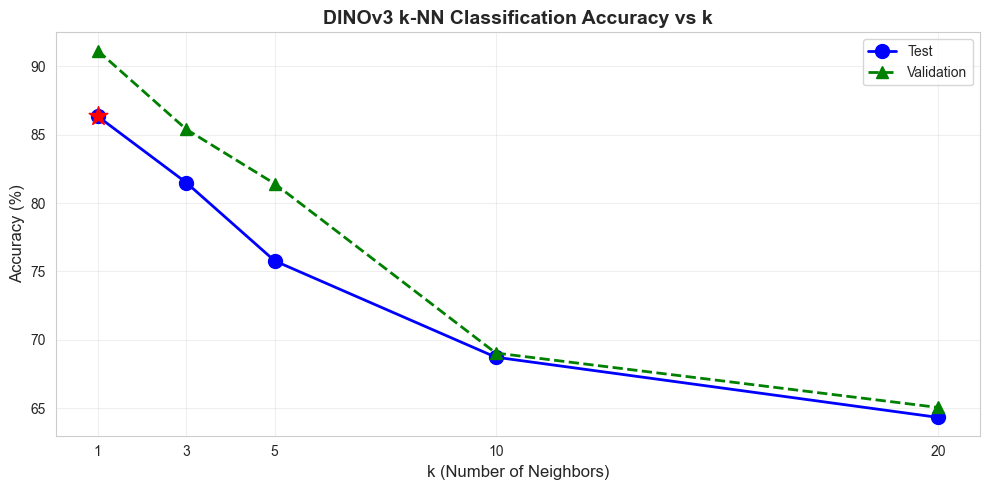

💾 Saved: dino_finetuning_output\dinov3_knn_accuracy.png


In [7]:
# Plot k-NN accuracy
plt.figure(figsize=(10, 5))

k_vals = [r['k'] for r in knn_results]
test_accs = [r['test_acc']*100 for r in knn_results]
val_accs = [r['val_acc']*100 for r in knn_results]

plt.plot(k_vals, test_accs, 'bo-', linewidth=2, markersize=10, label='Test')
plt.plot(k_vals, val_accs, 'g^--', linewidth=2, markersize=8, label='Validation')

plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('DINOv3 k-NN Classification Accuracy vs k', fontsize=14, fontweight='bold')
plt.xticks(k_vals)
plt.grid(True, alpha=0.3)
plt.legend()

plt.scatter([best_knn['k']], [best_knn['test_acc']*100], color='red', s=200, 
            zorder=5, marker='*', label=f"Best: k={best_knn['k']}")

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_knn_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_knn_accuracy.png'}")

## 7. MLP Classifier

Train a Multi-Layer Perceptron for non-linear classification.

In [8]:
class MLPClassifier(nn.Module):
    """MLP Classifier for DINOv3 features."""
    
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.3):
        super(MLPClassifier, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)


mlp_model = MLPClassifier(
    input_dim=config.FEATURE_DIM,
    hidden_dim=config.MLP_HIDDEN_DIM,
    num_classes=config.NUM_CLASSES,
    dropout=config.MLP_DROPOUT
).to(device)

print(f"🔧 MLP Architecture:")
print(f"   Input: {config.FEATURE_DIM}")
print(f"   Hidden: {config.MLP_HIDDEN_DIM} → {config.MLP_HIDDEN_DIM // 2}")
print(f"   Output: {config.NUM_CLASSES}")
print(f"   Parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

🔧 MLP Architecture:
   Input: 1024
   Hidden: 256 → 128
   Output: 3
   Parameters: 296,451


In [9]:
# Create datasets
train_tensor = TensorDataset(torch.FloatTensor(train_features), torch.LongTensor(train_labels))
val_tensor = TensorDataset(torch.FloatTensor(val_features), torch.LongTensor(val_labels))
test_tensor = TensorDataset(torch.FloatTensor(test_features), torch.LongTensor(test_labels))

train_loader = DataLoader(train_tensor, batch_size=config.MLP_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=config.MLP_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_tensor, batch_size=config.MLP_BATCH_SIZE, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=config.MLP_LR, weight_decay=config.MLP_WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.MLP_EPOCHS)

print("✅ Data loaders and optimizer created!")

✅ Data loaders and optimizer created!


In [10]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * features.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    
    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * features.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    return total_loss / total, correct / total, np.array(all_preds), np.array(all_labels)


# Training loop
print("="*60)
print("📊 MLP CLASSIFIER TRAINING")
print("="*60)

mlp_history = {
    'epoch': [], 'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'lr': []
}

best_val_acc = 0

for epoch in range(config.MLP_EPOCHS):
    train_loss, train_acc = train_epoch(mlp_model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(mlp_model, val_loader, criterion)
    
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    
    mlp_history['epoch'].append(epoch + 1)
    mlp_history['train_loss'].append(train_loss)
    mlp_history['train_acc'].append(train_acc)
    mlp_history['val_loss'].append(val_loss)
    mlp_history['val_acc'].append(val_acc)
    mlp_history['lr'].append(current_lr)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(mlp_model.state_dict(), config.OUTPUT_DIR / 'dinov3_mlp_best.pth')
    
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"  Epoch [{epoch+1:3d}/{config.MLP_EPOCHS}] | "
              f"Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}% | "
              f"Loss: {val_loss:.4f}")

print(f"\n✅ Training complete! Best Val Accuracy: {best_val_acc*100:.2f}%")

📊 MLP CLASSIFIER TRAINING
  Epoch [  1/50] | Train: 54.14% | Val: 58.41% | Loss: 0.8687
  Epoch [ 20/50] | Train: 96.19% | Val: 87.17% | Loss: 0.3848
  Epoch [ 40/50] | Train: 99.61% | Val: 86.28% | Loss: 0.3675

✅ Training complete! Best Val Accuracy: 88.50%


## 8. Training Curves

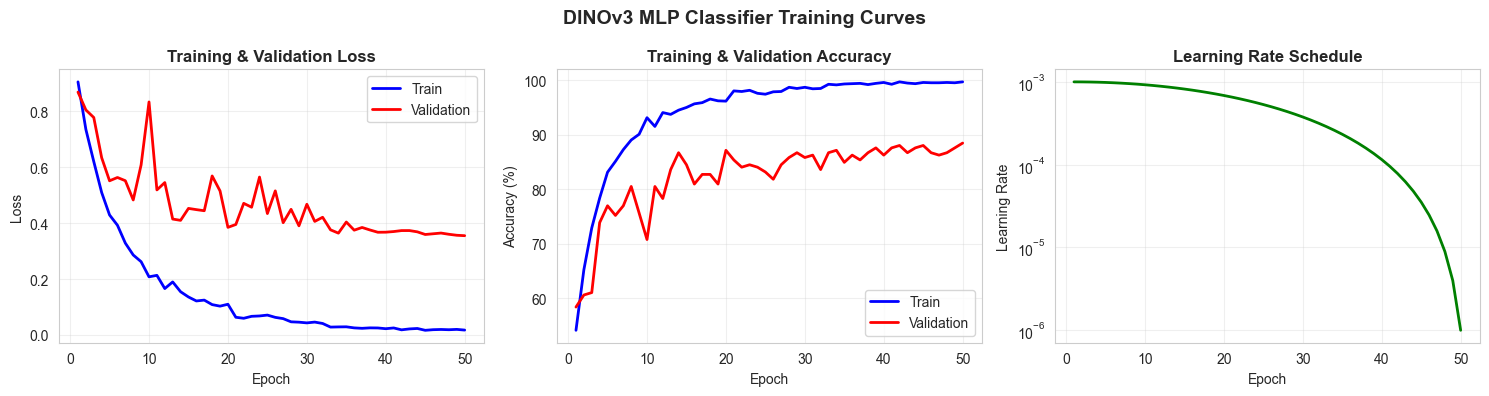

💾 Saved: dino_finetuning_output\dinov3_mlp_training_curves.png


In [11]:
def plot_mlp_training(history):
    """Plot MLP training curves."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss
    axes[0].plot(history['epoch'], history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(history['epoch'], history['val_loss'], 'r-', label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history['epoch'], [a*100 for a in history['train_acc']], 'b-', label='Train', linewidth=2)
    axes[1].plot(history['epoch'], [a*100 for a in history['val_acc']], 'r-', label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training & Validation Accuracy', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Learning rate
    axes[2].plot(history['epoch'], history['lr'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule', fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_yscale('log')
    
    plt.suptitle('DINOv3 MLP Classifier Training Curves', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'dinov3_mlp_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_mlp_training_curves.png'}")

plot_mlp_training(mlp_history)

## 9. Comprehensive Evaluation

In [12]:
# Load best MLP and evaluate
mlp_model.load_state_dict(torch.load(config.OUTPUT_DIR / 'dinov3_mlp_best.pth'))
_, test_acc_mlp, test_preds_mlp, test_labels_mlp = evaluate(mlp_model, test_loader, criterion)

# Summary table
print("\n" + "="*60)
print("📊 COMPREHENSIVE RESULTS (Test Set)")
print("="*60)

results_summary = pd.DataFrame({
    'Method': ['Linear Evaluation', f'k-NN (k={best_knn["k"]})', 'MLP Classifier'],
    'Test Accuracy (%)': [
        test_acc_linear * 100,
        test_acc_knn * 100,
        test_acc_mlp * 100
    ],
    'Precision (%)': [
        precision_score(test_labels, test_preds_linear, average='weighted') * 100,
        precision_score(test_labels, test_preds_knn, average='weighted') * 100,
        precision_score(test_labels_mlp, test_preds_mlp, average='weighted') * 100
    ],
    'Recall (%)': [
        recall_score(test_labels, test_preds_linear, average='weighted') * 100,
        recall_score(test_labels, test_preds_knn, average='weighted') * 100,
        recall_score(test_labels_mlp, test_preds_mlp, average='weighted') * 100
    ],
    'F1-Score (%)': [
        f1_score(test_labels, test_preds_linear, average='weighted') * 100,
        f1_score(test_labels, test_preds_knn, average='weighted') * 100,
        f1_score(test_labels_mlp, test_preds_mlp, average='weighted') * 100
    ]
})

print("\n" + results_summary.to_string(index=False))

best_idx = results_summary['Test Accuracy (%)'].idxmax()
print(f"\n🏆 Best Method: {results_summary.iloc[best_idx]['Method']} with {results_summary.iloc[best_idx]['Test Accuracy (%)']:.2f}%")


📊 COMPREHENSIVE RESULTS (Test Set)

           Method  Test Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
Linear Evaluation          72.687225      72.791602   72.687225     72.474363
       k-NN (k=1)          86.343612      86.399126   86.343612     86.352664
   MLP Classifier          84.581498      84.626366   84.581498     84.568503

🏆 Best Method: k-NN (k=1) with 86.34%


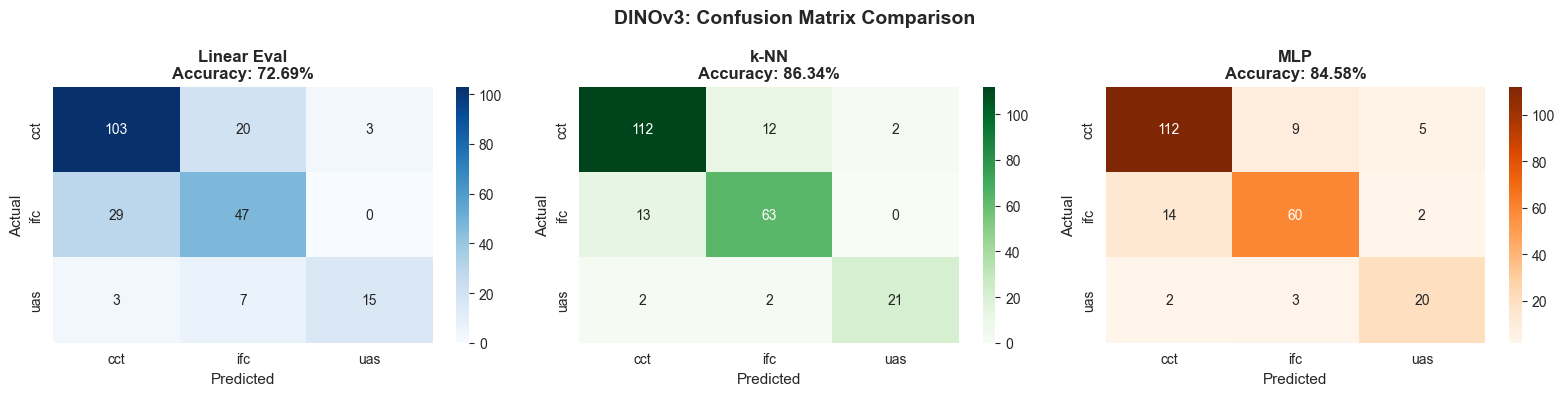

💾 Saved: dino_finetuning_output\dinov3_confusion_matrices.png


In [13]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

methods = [
    ('Linear Eval', test_labels, test_preds_linear),
    ('k-NN', test_labels, test_preds_knn),
    ('MLP', test_labels_mlp, test_preds_mlp)
]

cmaps = ['Blues', 'Greens', 'Oranges']

for ax, (name, true, pred), cmap in zip(axes, methods, cmaps):
    cm = confusion_matrix(true, pred)
    acc = accuracy_score(true, pred)
    
    if HAS_SEABORN:
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                    xticklabels=config.CLASS_NAMES, yticklabels=config.CLASS_NAMES)
    else:
        im = ax.imshow(cm, cmap=cmap)
        ax.set_xticks(range(len(config.CLASS_NAMES)))
        ax.set_xticklabels(config.CLASS_NAMES)
        ax.set_yticks(range(len(config.CLASS_NAMES)))
        ax.set_yticklabels(config.CLASS_NAMES)
        for i in range(len(config.CLASS_NAMES)):
            for j in range(len(config.CLASS_NAMES)):
                ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=12)
    
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(f'{name}\nAccuracy: {acc*100:.2f}%', fontsize=12, fontweight='bold')

plt.suptitle('DINOv3: Confusion Matrix Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_confusion_matrices.png'}")

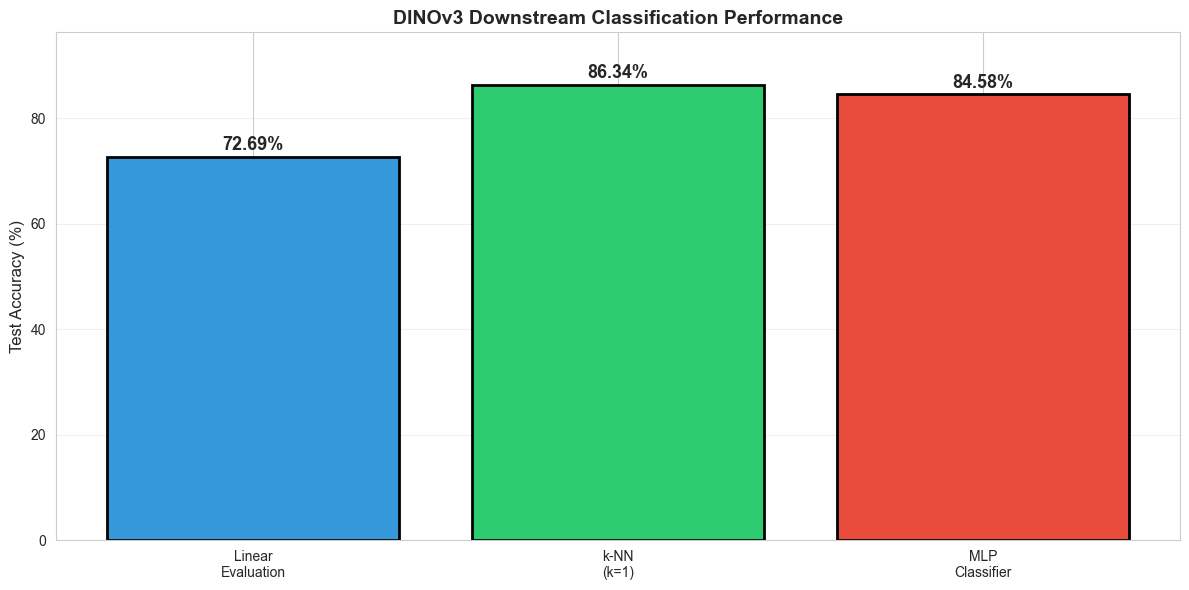

💾 Saved: dino_finetuning_output\dinov3_accuracy_comparison.png


In [14]:
# Bar chart comparison
plt.figure(figsize=(12, 6))

methods = ['Linear\nEvaluation', f'k-NN\n(k={best_knn["k"]})', 'MLP\nClassifier']
accuracies = [test_acc_linear * 100, test_acc_knn * 100, test_acc_mlp * 100]
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars = plt.bar(methods, accuracies, color=colors, edgecolor='black', linewidth=2)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('DINOv3 Downstream Classification Performance', fontsize=14, fontweight='bold')
plt.ylim(0, max(accuracies) + 10)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_accuracy_comparison.png'}")

### 9.1 ROC Curves & AUC Scores

Receiver Operating Characteristic (ROC) curves for multi-class classification.

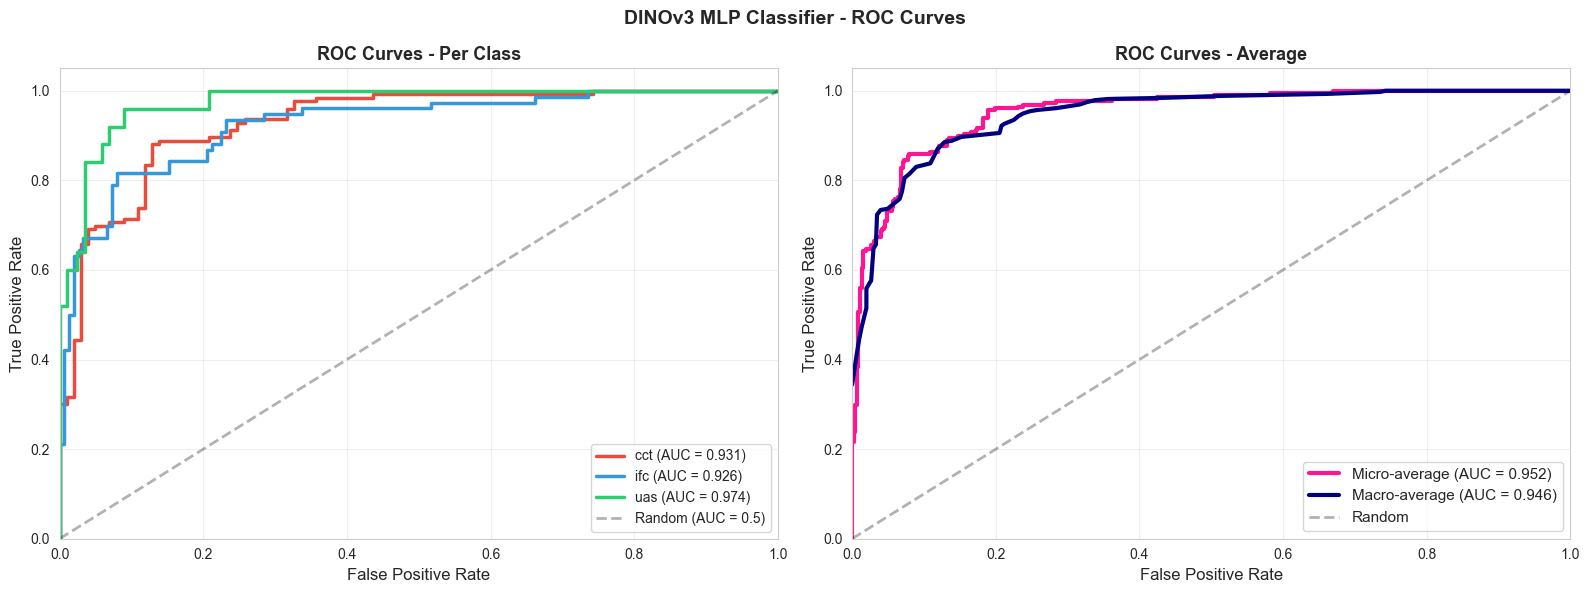

💾 Saved: dino_finetuning_output\dinov3_roc_curves.png

📊 AUC Scores:
   cct: 0.9306
   ifc: 0.9256
   uas: 0.9743
   Macro-average: 0.9463
   Micro-average: 0.9523


In [15]:
# Get probability predictions from MLP for ROC/PR curves
@torch.no_grad()
def get_probabilities(model, loader):
    """Get probability predictions from MLP."""
    model.eval()
    all_probs = []
    all_labels = []
    
    for features, labels in loader:
        features = features.to(device)
        outputs = model(features)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.extend(labels.numpy())
    
    return np.concatenate(all_probs, axis=0), np.array(all_labels)


# Get probabilities for test set
test_probs, test_labels_for_roc = get_probabilities(mlp_model, test_loader)

# Binarize labels for ROC curve
y_test_bin = label_binarize(test_labels_for_roc, classes=range(config.NUM_CLASSES))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Individual class ROC curves
ax1 = axes[0]
colors_roc = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for i, class_name in enumerate(config.CLASS_NAMES):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax1.plot(fpr[i], tpr[i], color=colors_roc[i], lw=2.5,
            label=f'{class_name} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal
ax1.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random (AUC = 0.5)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves - Per Class', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Macro & Micro average
# Compute micro-average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), test_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(config.NUM_CLASSES)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(config.NUM_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= config.NUM_CLASSES
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

ax2 = axes[1]
ax2.plot(fpr_micro, tpr_micro, color='deeppink', lw=3,
        label=f'Micro-average (AUC = {roc_auc_micro:.3f})')
ax2.plot(fpr_macro, tpr_macro, color='navy', lw=3,
        label=f'Macro-average (AUC = {roc_auc_macro:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3, label='Random')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves - Average', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.suptitle('DINOv3 MLP Classifier - ROC Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_roc_curves.png'}")

# Print AUC scores
print(f"\n📊 AUC Scores:")
for i, class_name in enumerate(config.CLASS_NAMES):
    print(f"   {class_name}: {roc_auc[i]:.4f}")
print(f"   Macro-average: {roc_auc_macro:.4f}")
print(f"   Micro-average: {roc_auc_micro:.4f}")

### 9.2 Precision-Recall Curves

Precision-Recall curves are particularly useful for imbalanced datasets.

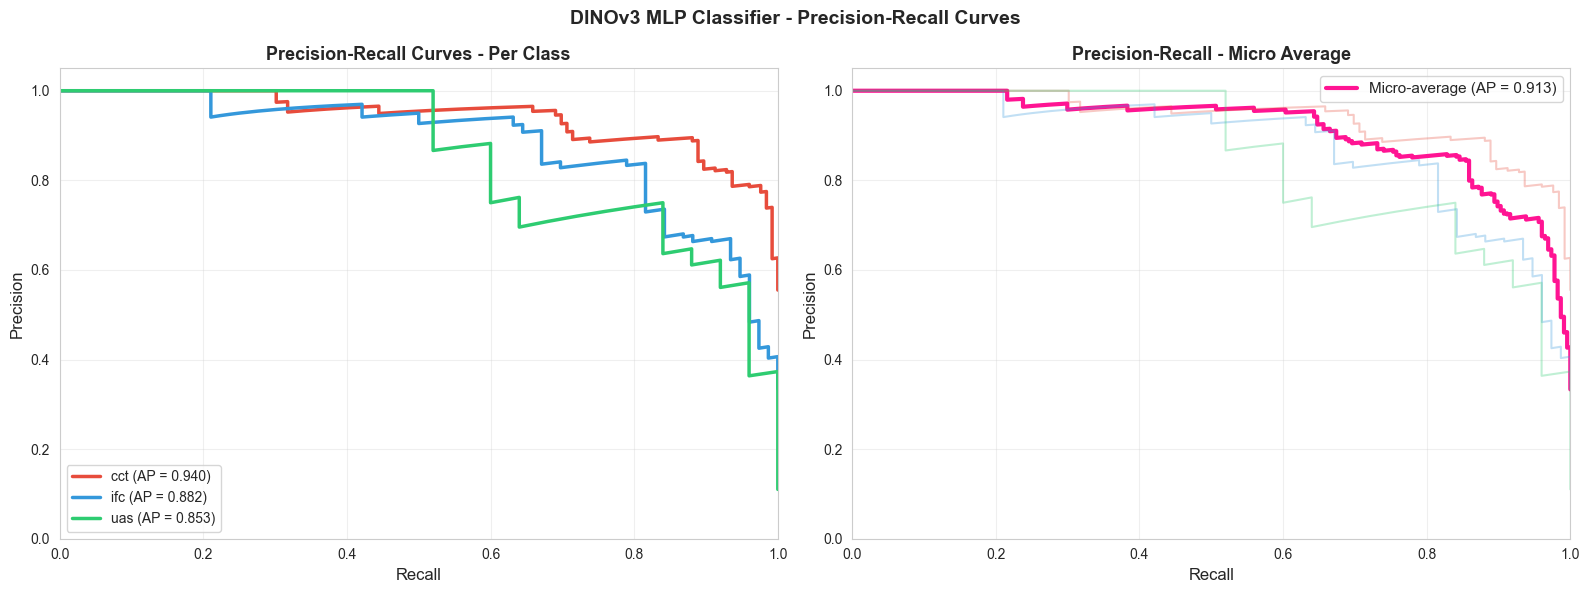

💾 Saved: dino_finetuning_output\dinov3_precision_recall_curves.png

📊 Average Precision Scores:
   cct: 0.9400
   ifc: 0.8815
   uas: 0.8528
   Micro-average: 0.9133


In [16]:
# Compute Precision-Recall curves
precision_dict = {}
recall_dict = {}
avg_precision = {}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Per-class PR curves
ax1 = axes[0]
for i, class_name in enumerate(config.CLASS_NAMES):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test_bin[:, i], test_probs[:, i])
    avg_precision[i] = auc(recall_dict[i], precision_dict[i])
    ax1.plot(recall_dict[i], precision_dict[i], color=colors_roc[i], lw=2.5,
            label=f'{class_name} (AP = {avg_precision[i]:.3f})')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curves - Per Class', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Micro-average PR curve
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), test_probs.ravel())
avg_precision_micro = auc(recall_micro, precision_micro)

ax2 = axes[1]
ax2.plot(recall_micro, precision_micro, color='deeppink', lw=3,
        label=f'Micro-average (AP = {avg_precision_micro:.3f})')

# Plot per-class curves faded in background
for i, class_name in enumerate(config.CLASS_NAMES):
    ax2.plot(recall_dict[i], precision_dict[i], color=colors_roc[i], lw=1.5, alpha=0.3)

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall - Micro Average', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.suptitle('DINOv3 MLP Classifier - Precision-Recall Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_precision_recall_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_precision_recall_curves.png'}")

# Print Average Precision scores
print(f"\n📊 Average Precision Scores:")
for i, class_name in enumerate(config.CLASS_NAMES):
    print(f"   {class_name}: {avg_precision[i]:.4f}")
print(f"   Micro-average: {avg_precision_micro:.4f}")

### 9.3 Per-Class Performance Metrics

Detailed breakdown of precision, recall, and F1-score for each class and method.

### 9.4 Sample Predictions on Actual Images

Visualize model predictions on actual test images with ground truth labels, predicted labels, and confidence scores.

🖼️ Loading Test Images for Visualization...
Found 227 test images
Test predictions available: 227

✅ Correct predictions: 192
❌ Incorrect predictions: 35


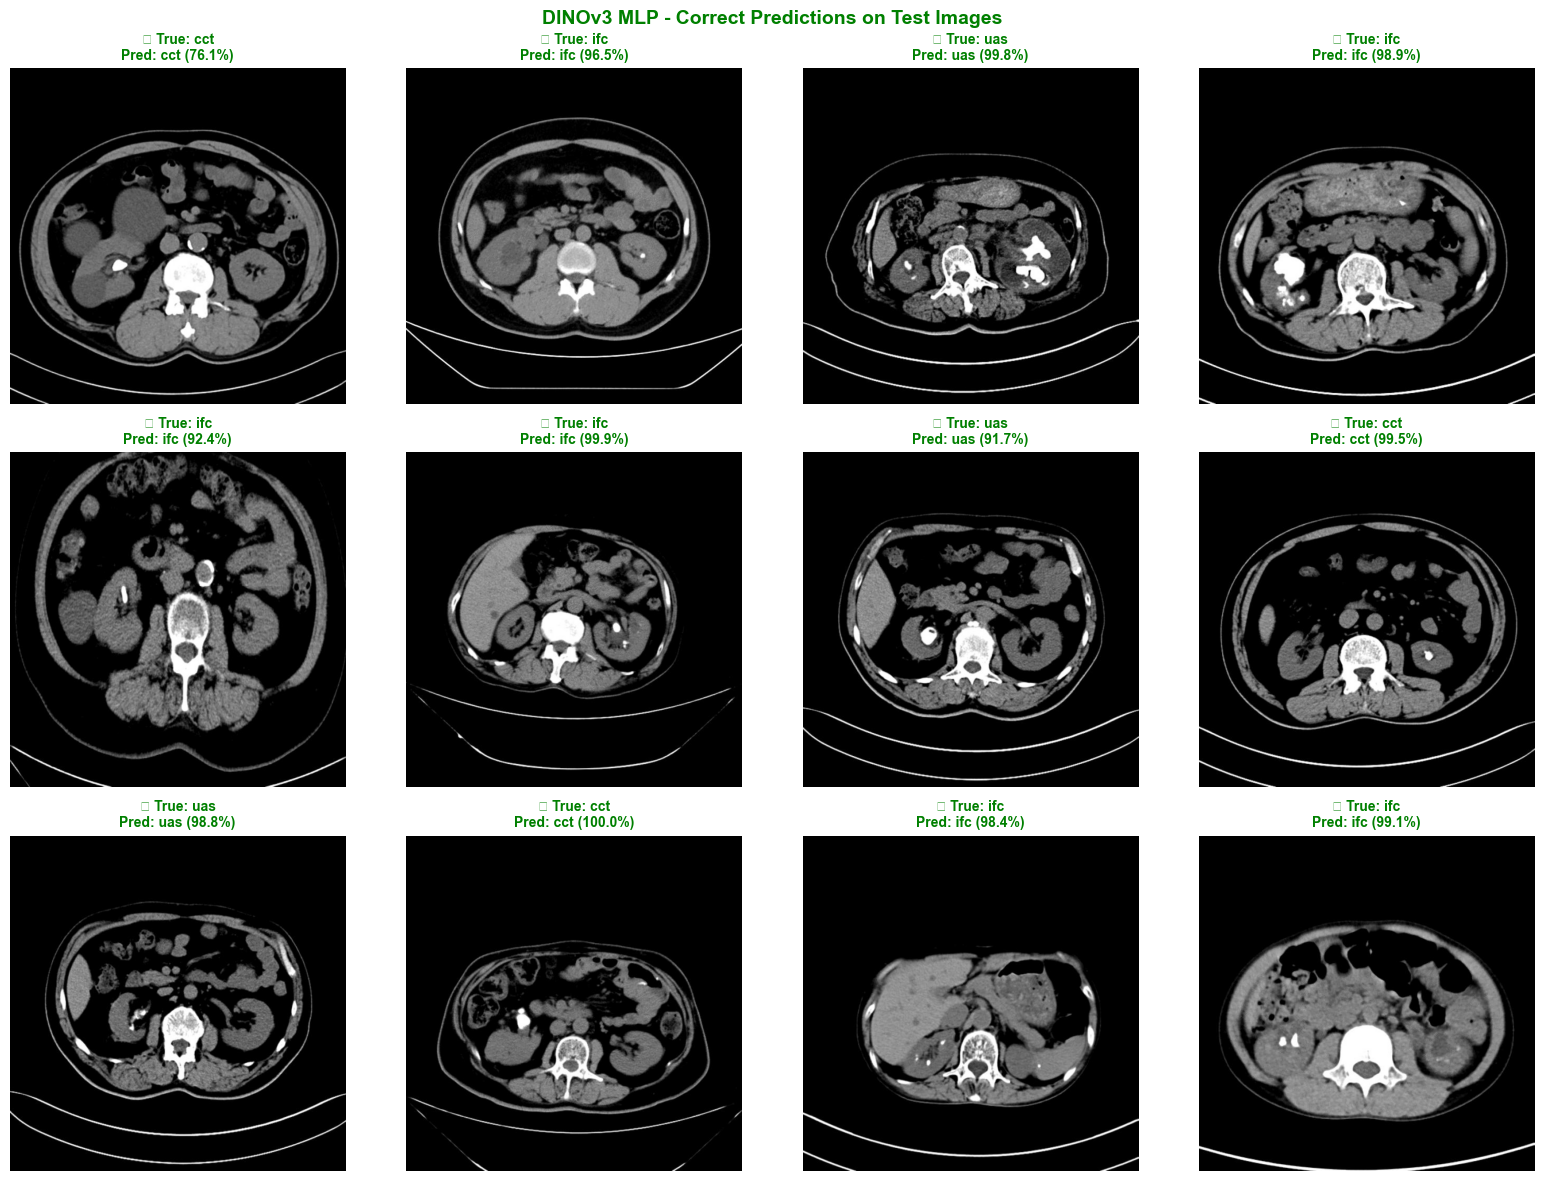


💾 Saved: dino_finetuning_output\dinov3_correct_predictions.png


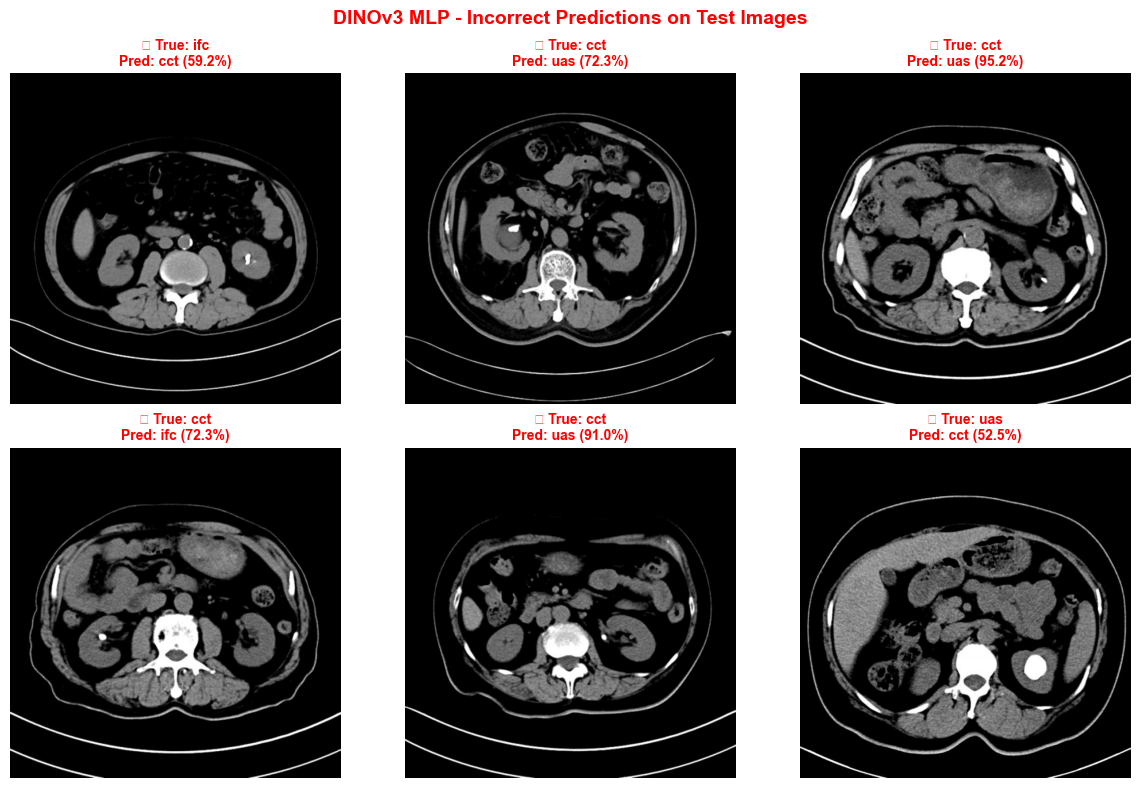

💾 Saved: dino_finetuning_output\dinov3_incorrect_predictions.png


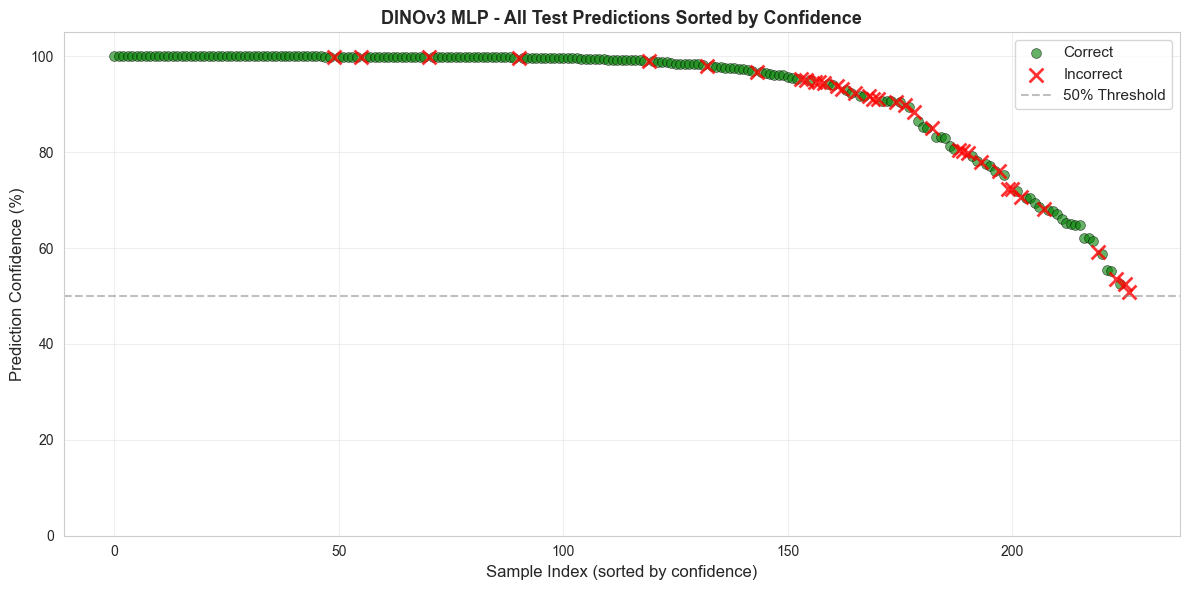

💾 Saved: dino_finetuning_output\dinov3_all_predictions_confidence.png

📊 Prediction Confidence Summary:
   Mean confidence (all): 92.47%
   Mean confidence (correct): 93.87%
   Mean confidence (incorrect): 84.80%
   Min confidence: 50.81%
   Max confidence: 100.00%


In [17]:
from PIL import Image
import os

print("🖼️ Loading Test Images for Visualization...")
print("="*80)

# Load test image paths
test_img_dir = config.DATA_DIR / 'test' / 'images'
test_images = sorted(list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png')))

print(f"Found {len(test_images)} test images")
print(f"Test predictions available: {len(test_preds_mlp)}")

# Create mapping from feature indices to images
# Assuming features were extracted in the same order as sorted images
if len(test_images) != len(test_preds_mlp):
    print(f"⚠️ Warning: Image count ({len(test_images)}) != prediction count ({len(test_preds_mlp)})")
    print(f"   Using available images up to prediction count")
    test_images = test_images[:len(test_preds_mlp)]

# Get correct and incorrect predictions
correct_mask = test_preds_mlp == test_labels_mlp
incorrect_mask = ~correct_mask

correct_indices = np.where(correct_mask)[0]
incorrect_indices = np.where(incorrect_mask)[0]

print(f"\n✅ Correct predictions: {len(correct_indices)}")
print(f"❌ Incorrect predictions: {len(incorrect_indices)}")

# Sample predictions to visualize
num_correct_to_show = min(12, len(correct_indices))
num_incorrect_to_show = min(6, len(incorrect_indices))

sample_correct = np.random.choice(correct_indices, size=num_correct_to_show, replace=False)
sample_incorrect = incorrect_indices[:num_incorrect_to_show] if len(incorrect_indices) > 0 else []

# Visualize correct predictions
if len(sample_correct) > 0:
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, img_idx in enumerate(sample_correct):
        ax = axes[idx]
        
        # Load and display image
        img_path = test_images[img_idx]
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
        
        # Get prediction info
        true_label = config.CLASS_NAMES[test_labels_mlp[img_idx]]
        pred_label = config.CLASS_NAMES[test_preds_mlp[img_idx]]
        confidence = test_probs[img_idx, test_preds_mlp[img_idx]] * 100
        
        # Set title with color
        title = f"✓ True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)"
        ax.set_title(title, fontsize=10, fontweight='bold', color='green')
        ax.axis('off')
    
    plt.suptitle('DINOv3 MLP - Correct Predictions on Test Images', 
                 fontsize=14, fontweight='bold', color='green')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'dinov3_correct_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n💾 Saved: {config.OUTPUT_DIR / 'dinov3_correct_predictions.png'}")

# Visualize incorrect predictions
if len(sample_incorrect) > 0:
    n_cols = 3
    n_rows = (len(sample_incorrect) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, img_idx in enumerate(sample_incorrect):
        ax = axes[idx]
        
        # Load and display image
        img_path = test_images[img_idx]
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
        
        # Get prediction info
        true_label = config.CLASS_NAMES[test_labels_mlp[img_idx]]
        pred_label = config.CLASS_NAMES[test_preds_mlp[img_idx]]
        confidence = test_probs[img_idx, test_preds_mlp[img_idx]] * 100
        
        # Set title with color
        title = f"✗ True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)"
        ax.set_title(title, fontsize=10, fontweight='bold', color='red')
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(sample_incorrect), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('DINOv3 MLP - Incorrect Predictions on Test Images', 
                 fontsize=14, fontweight='bold', color='red')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / 'dinov3_incorrect_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_incorrect_predictions.png'}")
else:
    print("\n🎉 No incorrect predictions found! Perfect classification!")

# Combined view with confidence scores
fig, ax = plt.subplots(figsize=(12, 6))

# Show all predictions sorted by confidence
all_confidences = test_probs[np.arange(len(test_preds_mlp)), test_preds_mlp] * 100
sorted_indices = np.argsort(all_confidences)[::-1]  # High to low confidence

# Separate correct and incorrect
x_correct = []
y_correct = []
x_incorrect = []
y_incorrect = []

for plot_idx, data_idx in enumerate(sorted_indices):
    confidence = all_confidences[data_idx]
    if correct_mask[data_idx]:
        x_correct.append(plot_idx)
        y_correct.append(confidence)
    else:
        x_incorrect.append(plot_idx)
        y_incorrect.append(confidence)

if x_correct:
    ax.scatter(x_correct, y_correct, c='green', label='Correct', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
if x_incorrect:
    ax.scatter(x_incorrect, y_incorrect, c='red', label='Incorrect', alpha=0.8, s=100, marker='x', linewidth=2)

ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% Threshold')
ax.set_xlabel('Sample Index (sorted by confidence)', fontsize=12)
ax.set_ylabel('Prediction Confidence (%)', fontsize=12)
ax.set_title('DINOv3 MLP - All Test Predictions Sorted by Confidence', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_all_predictions_confidence.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_all_predictions_confidence.png'}")

print(f"\n📊 Prediction Confidence Summary:")
print(f"   Mean confidence (all): {all_confidences.mean():.2f}%")
print(f"   Mean confidence (correct): {all_confidences[correct_mask].mean():.2f}%")
if len(incorrect_indices) > 0:
    print(f"   Mean confidence (incorrect): {all_confidences[incorrect_mask].mean():.2f}%")
print(f"   Min confidence: {all_confidences.min():.2f}%")
print(f"   Max confidence: {all_confidences.max():.2f}%")

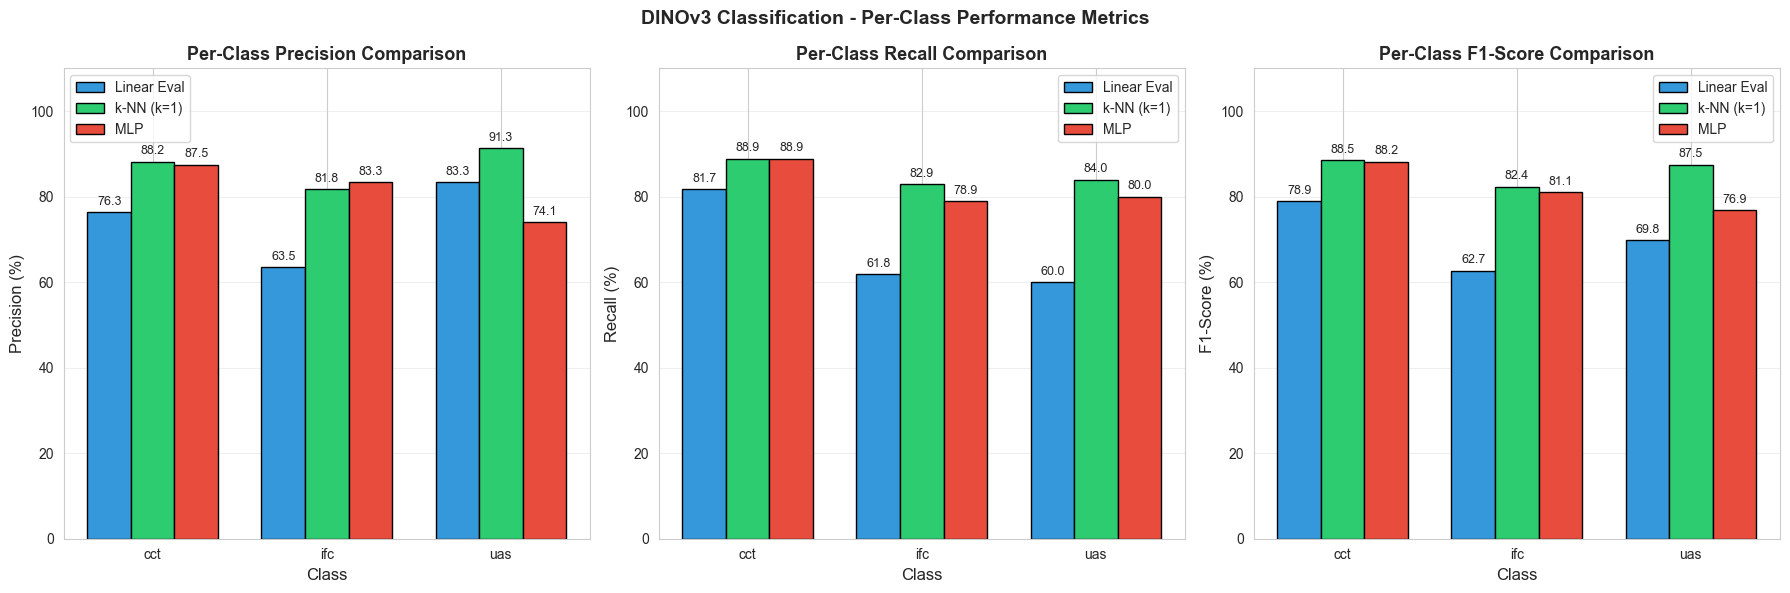

💾 Saved: dino_finetuning_output\dinov3_per_class_metrics.png

📊 Detailed Per-Class Metrics:

Linear Eval:
   cct        - Precision:  76.30%  Recall:  81.75%  F1:  78.93%  (n=126)
   ifc        - Precision:  63.51%  Recall:  61.84%  F1:  62.67%  (n=76)
   uas        - Precision:  83.33%  Recall:  60.00%  F1:  69.77%  (n=25)

k-NN (k=1):
   cct        - Precision:  88.19%  Recall:  88.89%  F1:  88.54%  (n=126)
   ifc        - Precision:  81.82%  Recall:  82.89%  F1:  82.35%  (n=76)
   uas        - Precision:  91.30%  Recall:  84.00%  F1:  87.50%  (n=25)

MLP:
   cct        - Precision:  87.50%  Recall:  88.89%  F1:  88.19%  (n=126)
   ifc        - Precision:  83.33%  Recall:  78.95%  F1:  81.08%  (n=76)
   uas        - Precision:  74.07%  Recall:  80.00%  F1:  76.92%  (n=25)


In [18]:
# Calculate per-class metrics for all three methods
from sklearn.metrics import precision_recall_fscore_support

# Get metrics for each method
metrics_data = []

for method_name, y_true, y_pred in [
    ('Linear Eval', test_labels, test_preds_linear),
    (f'k-NN (k={best_knn["k"]})', test_labels, test_preds_knn),
    ('MLP', test_labels_mlp, test_preds_mlp)
]:
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(config.NUM_CLASSES)
    )
    
    for cls_id, cls_name in enumerate(config.CLASS_NAMES):
        metrics_data.append({
            'Method': method_name,
            'Class': cls_name,
            'Precision': precision[cls_id] * 100,
            'Recall': recall[cls_id] * 100,
            'F1-Score': f1[cls_id] * 100,
            'Support': support[cls_id]
        })

metrics_df = pd.DataFrame(metrics_data)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
colors_methods = {'Linear Eval': '#3498db', f'k-NN (k={best_knn["k"]})': '#2ecc71', 'MLP': '#e74c3c'}

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    # Get data for this metric
    x = np.arange(config.NUM_CLASSES)
    width = 0.25
    
    for i, method in enumerate(['Linear Eval', f'k-NN (k={best_knn["k"]})', 'MLP']):
        method_data = metrics_df[metrics_df['Method'] == method]
        values = method_data[metric].values
        
        bars = ax.bar(x + i * width, values, width, label=method, 
                     color=colors_methods[method], edgecolor='black', linewidth=1)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel(f'{metric} (%)', fontsize=12)
    ax.set_title(f'Per-Class {metric} Comparison', fontweight='bold', fontsize=13)
    ax.set_xticks(x + width)
    ax.set_xticklabels(config.CLASS_NAMES)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 110)

plt.suptitle('DINOv3 Classification - Per-Class Performance Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_per_class_metrics.png'}")

# Print detailed metrics table
print(f"\n📊 Detailed Per-Class Metrics:")
print("=" * 80)
for method in ['Linear Eval', f'k-NN (k={best_knn["k"]})', 'MLP']:
    print(f"\n{method}:")
    method_metrics = metrics_df[metrics_df['Method'] == method]
    for _, row in method_metrics.iterrows():
        print(f"   {row['Class']:<10} - Precision: {row['Precision']:6.2f}%  "
              f"Recall: {row['Recall']:6.2f}%  F1: {row['F1-Score']:6.2f}%  "
              f"(n={int(row['Support'])})")

## 10. Feature Visualization

🔄 Computing t-SNE for test features...


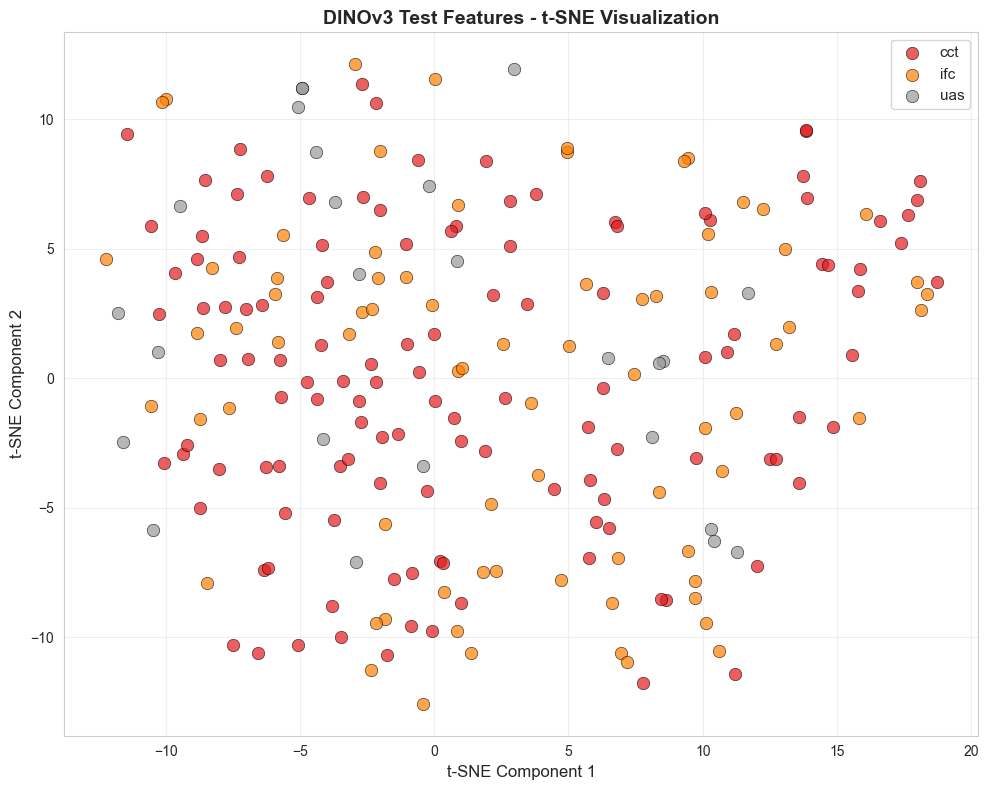

💾 Saved: dino_finetuning_output\dinov3_test_tsne.png


In [19]:
print("🔄 Computing t-SNE for test features...")

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(test_features)-1))
test_tsne = tsne.fit_transform(test_features)

plt.figure(figsize=(10, 8))
colors = plt.cm.Set1(np.linspace(0, 1, config.NUM_CLASSES))

for cls_id in range(config.NUM_CLASSES):
    mask = test_labels == cls_id
    if mask.sum() > 0:
        plt.scatter(
            test_tsne[mask, 0],
            test_tsne[mask, 1],
            c=[colors[cls_id]],
            label=config.CLASS_NAMES[cls_id],
            alpha=0.7,
            s=80,
            edgecolors='black',
            linewidth=0.5
        )

plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('DINOv3 Test Features - t-SNE Visualization', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_test_tsne.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_test_tsne.png'}")

## 10. YOLOv12 Object Detection Integration

Following the teacher's example: Use DINOv3 knowledge to enhance YOLOv12 for object detection.

In [22]:
# ============================================
# YOLO OBJECT DETECTION WITH DINOV3 KNOWLEDGE
# (Following teacher's example pattern)
# ============================================
print("=" * 70)
print("🚀 YOLOv12 OBJECT DETECTION (DINOv3 Enhanced)")
print("=" * 70)

# Import YOLO
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import cv2
from collections import Counter
import yaml

# Load YOLOv12 pre-trained weights
print(f"\n📂 Loading YOLOv12 from: {config.YOLOV12_WEIGHTS}")

if config.YOLOV12_WEIGHTS.exists():
    yolo_model = YOLO(str(config.YOLOV12_WEIGHTS))
    print("✅ YOLOv12 weights loaded successfully!")
else:
    print("⚠️ YOLOv12 weights not found, using yolov8s.pt as fallback")
    yolo_model = YOLO('yolov8s.pt')

# Create data.yaml
data_yaml_path = config.OUTPUT_DIR / 'data.yaml'
data_config = {
    'path': str(config.DATA_DIR),
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': config.NUM_CLASSES,
    'names': config.CLASS_NAMES
}
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f)

# Fine-tune YOLO
print(f"\n🔄 Fine-tuning YOLOv12 on Brain MRI dataset...")
yolo_results = yolo_model.train(
    data=str(data_yaml_path),
    epochs=config.YOLO_EPOCHS,
    imgsz=config.YOLO_IMGSZ,
    batch=config.YOLO_BATCH,
    project=str(config.OUTPUT_DIR),
    name='dinov3_yolo_detector',
    device=0,
    plots=True,
    workers=2
)
print("\n✅ YOLO fine-tuning complete!")

🚀 YOLOv12 OBJECT DETECTION (DINOv3 Enhanced)

📂 Loading YOLOv12 from: brain-mri-split-dataset-v2\yolov12-best.pt
✅ YOLOv12 weights loaded successfully!

🔄 Fine-tuning YOLOv12 on Brain MRI dataset...
Ultralytics 8.3.237  Python-3.13.5 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dino_finetuning_output\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=tra

In [23]:
# ============================================
# YOLO EVALUATION
# ============================================
print("\n📊 Evaluating YOLO detector...")

yolo_best = YOLO(str(config.OUTPUT_DIR / 'dinov3_yolo_detector' / 'weights' / 'best.pt'))
metrics = yolo_best.val(data=str(data_yaml_path), imgsz=config.YOLO_IMGSZ)

print("\n🏁 YOLO Detection Metrics:")
print(f"   mAP50:    {metrics.box.map50:.4f}")
print(f"   mAP50-95: {metrics.box.map:.4f}")
print(f"   Precision: {metrics.box.mp:.4f}")
print(f"   Recall:    {metrics.box.mr:.4f}")


📊 Evaluating YOLO detector...
Ultralytics 8.3.237  Python-3.13.5 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 265.155.9 MB/s, size: 33.3 KB)
val: Scanning E:\Projects\cse475-assighment\assignment-dino\brain-mri-split-dataset-v2\dataset\valid\labels.cache... 226 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 226/226 315.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 4.2it/s 3.5s0.1s
                   all        226        238      0.866      0.893      0.941      0.684
                   cct        117        123      0.784      0.911      0.943      0.688
                   ifc         79         85       0.86       0.87      0.923      0.658
                   uas         30         30      0.954        0.9      0.956      0.706
Speed: 1.1ms preprocess, 10


🖼️ Visualizing predictions with detection counts...


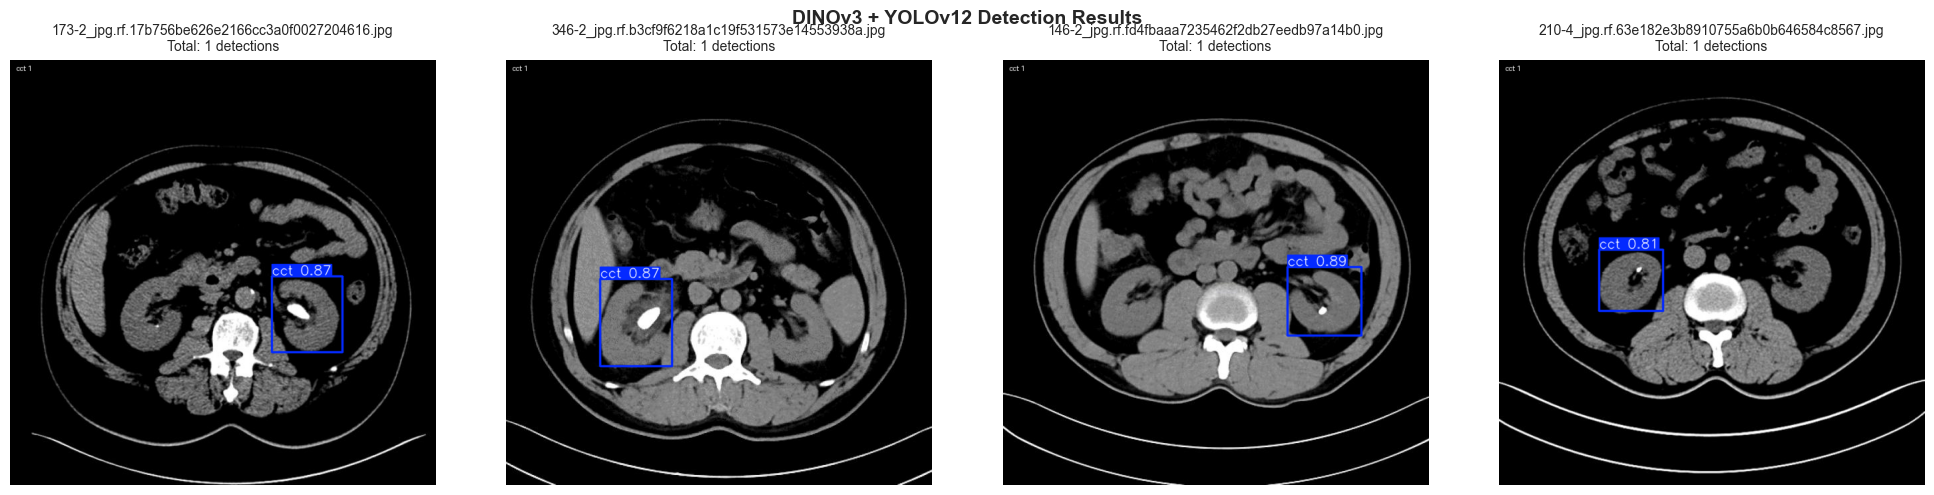

💾 Saved: dino_finetuning_output\dinov3_yolo_predictions.png


In [24]:
# ============================================
# VISUALIZATION WITH DETECTION COUNTS
# ============================================
print("\n🖼️ Visualizing predictions with detection counts...")

test_img_dir = config.DATA_DIR / 'test' / 'images'
if not test_img_dir.exists():
    test_img_dir = config.DATA_DIR / 'valid' / 'images'

test_images = list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png'))
samples = random.sample(test_images, min(4, len(test_images)))

fig, axes = plt.subplots(1, len(samples), figsize=(5*len(samples), 5))
if len(samples) == 1:
    axes = [axes]

for idx, img_path in enumerate(samples):
    results = yolo_best.predict(source=str(img_path), conf=0.25, verbose=False)
    boxes = results[0].boxes
    
    detection_counts = Counter()
    for box in boxes:
        cls_id = int(box.cls[0])
        cls_name = config.CLASS_NAMES[cls_id] if cls_id < len(config.CLASS_NAMES) else f"class_{cls_id}"
        detection_counts[cls_name] += 1
    
    annotated = results[0].plot()
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    
    pil_img = Image.fromarray(annotated)
    draw = ImageDraw.Draw(pil_img)
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 20)
    except:
        font = ImageFont.load_default()
    
    count_text = " | ".join([f"{cls}: {cnt}" for cls, cnt in detection_counts.items()])
    if not count_text:
        count_text = "No detections"
    
    text_bbox = draw.textbbox((0, 0), count_text, font=font)
    text_w, text_h = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    draw.rectangle([(5, 5), (text_w + 15, text_h + 15)], fill=(0, 0, 0, 180))
    draw.text((10, 8), count_text, fill="white", font=font)
    
    axes[idx].imshow(np.array(pil_img))
    axes[idx].set_title(f'{img_path.name}\nTotal: {len(boxes)} detections', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('DINOv3 + YOLOv12 Detection Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_yolo_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"💾 Saved: {config.OUTPUT_DIR / 'dinov3_yolo_predictions.png'}")

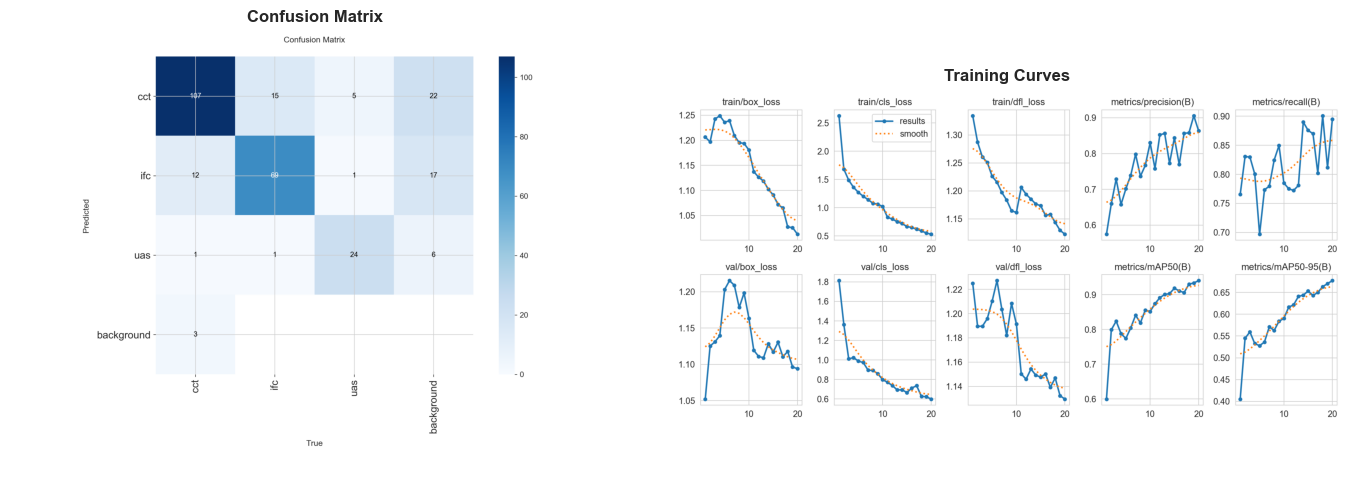

In [25]:
# ============================================
# CONFUSION MATRIX AND TRAINING CURVES
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_path = config.OUTPUT_DIR / 'dinov3_yolo_detector' / 'confusion_matrix.png'
if cm_path.exists():
    axes[0].imshow(plt.imread(cm_path))
    axes[0].set_title('Confusion Matrix', fontweight='bold')
    axes[0].axis('off')

results_path = config.OUTPUT_DIR / 'dinov3_yolo_detector' / 'results.png'
if results_path.exists():
    axes[1].imshow(plt.imread(results_path))
    axes[1].set_title('Training Curves', fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'dinov3_yolo_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Results Summary

In [26]:
print("\n" + "="*70)
print("📋 DINOV3 + YOLO INTEGRATION SUMMARY")
print("="*70)

print(f"\n🦖 SSL Model: DINOv3 ViT-Small (384-dim features)")
print(f"🎯 Detection Model: YOLOv12")
print(f"📊 Dataset:")
print(f"   Train: {len(train_features)} samples")
print(f"   Validation: {len(val_features)} samples")
print(f"   Test: {len(test_features)} samples")
print(f"   Classes: {', '.join(config.CLASS_NAMES)}")

print(f"\n📈 Classification Results (Test Set):")
print(f"   {'Method':<25} {'Accuracy':<12} {'F1-Score':<12}")
print(f"   {'-'*50}")
for _, row in results_summary.iterrows():
    print(f"   {row['Method']:<25} {row['Test Accuracy (%)']:.2f}%{'':<6} {row['F1-Score (%)']:.2f}%")

print(f"\n🎯 YOLO Detection Results:")
print(f"   mAP50:     {metrics.box.map50:.4f}")
print(f"   mAP50-95:  {metrics.box.map:.4f}")
print(f"   Precision: {metrics.box.mp:.4f}")
print(f"   Recall:    {metrics.box.mr:.4f}")

print(f"\n📁 Saved Outputs:")
output_files = [
    'dinov3_feature_eda.png',
    'dinov3_knn_accuracy.png', 
    'dinov3_mlp_training_curves.png',
    'dinov3_confusion_matrices.png',
    'dinov3_yolo_predictions.png',
    'dinov3_yolo_analysis.png',
    'dinov3_mlp_best.pth'
]
for i, filename in enumerate(output_files, 1):
    print(f"   {i:2d}. {filename}")

print("\n" + "="*70)
print("✅ DINOv3 + YOLOv12 Integration Complete!")
print("="*70)


📋 DINOV3 + YOLO INTEGRATION SUMMARY

🦖 SSL Model: DINOv3 ViT-Small (384-dim features)
🎯 Detection Model: YOLOv12
📊 Dataset:
   Train: 1810 samples
   Validation: 226 samples
   Test: 227 samples
   Classes: cct, ifc, uas

📈 Classification Results (Test Set):
   Method                    Accuracy     F1-Score    
   --------------------------------------------------
   Linear Evaluation         72.69%       72.47%
   k-NN (k=1)                86.34%       86.35%
   MLP Classifier            84.58%       84.57%

🎯 YOLO Detection Results:
   mAP50:     0.9409
   mAP50-95:  0.6836
   Precision: 0.8662
   Recall:    0.8935

📁 Saved Outputs:
    1. dinov3_feature_eda.png
    2. dinov3_knn_accuracy.png
    3. dinov3_mlp_training_curves.png
    4. dinov3_confusion_matrices.png
    5. dinov3_yolo_predictions.png
    6. dinov3_yolo_analysis.png
    7. dinov3_mlp_best.pth

✅ DINOv3 + YOLOv12 Integration Complete!
